In [3]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
from numpy.random import multinomial
import matplotlib.pyplot as plt
import random

# Bandit helper functions helper functions

These can be found in `src/` as well, but we show them here for illustration.

In [4]:
# Helper function to get equal sized bins for initialization.
def make_equal_bin_sizes(arr,n_bins):
    k, m = divmod(len(arr), n_bins)
    return list(arr[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n_bins))

# Greedy sampler, takes a "value matrix" and reassigns each sample to the max value generative model
def greedy_sampler(prob_mtrx):
    amax=np.argmax(prob_mtrx,axis=1)
    indx_bins=[np.where(amax==i)[0] for i in range(prob_mtrx.shape[-1]) ]
    return indx_bins

# Not really boltzmann sampling, just sampling from a multinomial distribution. If the probabilities are generated from "boltzmann" this is boltzmann sampling
def boltzmann_sampling(prob_mtrx):
    samples = np.asarray([multinomial(1, p) for p in prob_mtrx])

    indx_bins = [np.where(samples[:, i])[0] for i in range(samples.shape[-1])]
    return indx_bins

# Generates boltzmann distributions from value matrix (high value = hight probability)
def boltzmann(logP_mtrx,tau):
    
    score=np.sum(np.max(logP_mtrx,axis=1))
    P_mtrx = np.exp(logP_mtrx/tau)
    prob_mtrx = P_mtrx / np.sum(P_mtrx, axis=1)[:, None]
    assert all(np.abs(np.sum(prob_mtrx, axis=1) - 1.0) < 0.01), 'probabilites dont sum to 1'

    return prob_mtrx,score

# Generate some data

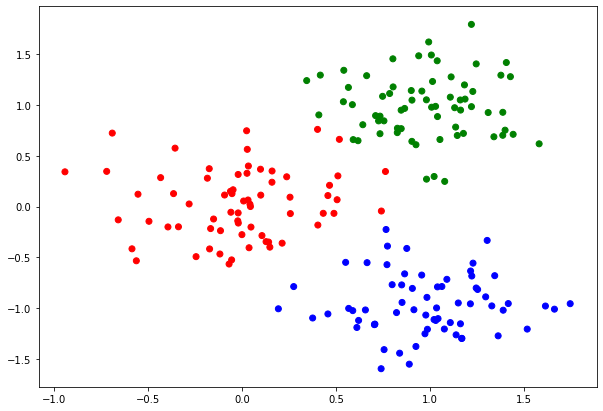

In [5]:
n_samples=200
colors=np.array(['r','g','b'])
X,y = datasets.make_blobs(n_samples=n_samples,centers=[[0,0],[1,1],[1,-1]],cluster_std=[0.3,0.3,0.3] ,random_state=8)

plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],color=colors[y])
plt.show()

# As reference we try to find the clusters with a standard GMM with $K=3$

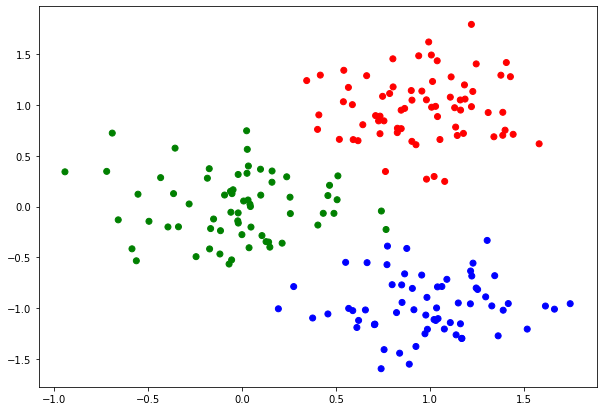

In [6]:
gmm=GMM(n_components=3)
gmm.fit(X)
y_gmm=gmm.predict(X)

plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],color=colors[y_gmm])
plt.show()

# Let's do the same thing with BEEM.
#### Here we have 3 distinct GMMs with $K=1$ mixtures each. The samples are split in to $K=3$ equal sized bins at initialisation, the parameters of each GMM is then estimated from samples in its assigned bin. 

#### At each itteration the log likelihood is computed for each sample and component. The bins are then resampled according to some exploration/exploitation mechanism such that samples that are similar end up in the same bin. After bin reassignment parameter estimation follows.

In [16]:
num_iter=100 # number of iterations
tau=1 # parameter that controls level of exploration (for boltzmann distribution)
K=3 # Number of clusters

indices=np.arange(0,len(X))  # Indices to sample from
random.shuffle(indices) # Shuffle in-place (i.e. mutate the original array)
bins=make_equal_bin_sizes(indices,n_bins=K) # Bin initialization. If indices are ordered this should be shuffled.
logP_mtrx=np.empty([len(X),K]) #Initialize value matrix (in this case log likelihood matrix, could be KLD or some other loss.)
components=[GMM(n_components=1) for i in range(K)] #initialize each component generative model ( in this case GMMS)

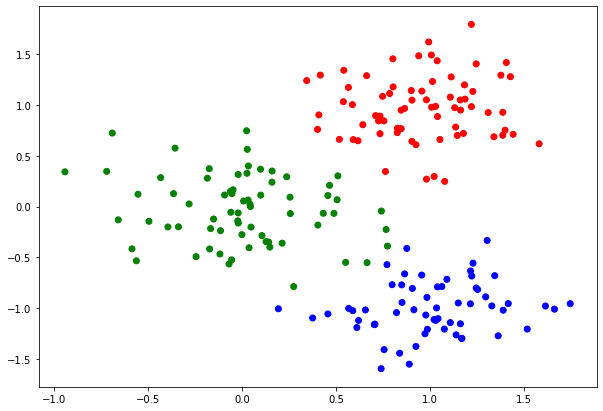

In [17]:
track_score = []
for iteration in range(num_iter):
    
    for k,component in enumerate(components):
        component.fit(X[bins[k]]) # Estimate parameters for generative model k
        logP_mtrx[:,k]=component.score_samples(X) # Compute and store value function for !!ALL SAMPLES!! (in this case log likelihood)
        
    p_mtrx,score=boltzmann(logP_mtrx,tau=tau)  # Generate probability distribution from value matrix
    track_score.append(score)
    # Sample from generated probability distribution
    bins=boltzmann_sampling(p_mtrx) 
        
#Plot the results
y_band=np.argmax(p_mtrx,axis=1)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],color=colors[y_band])
plt.show()

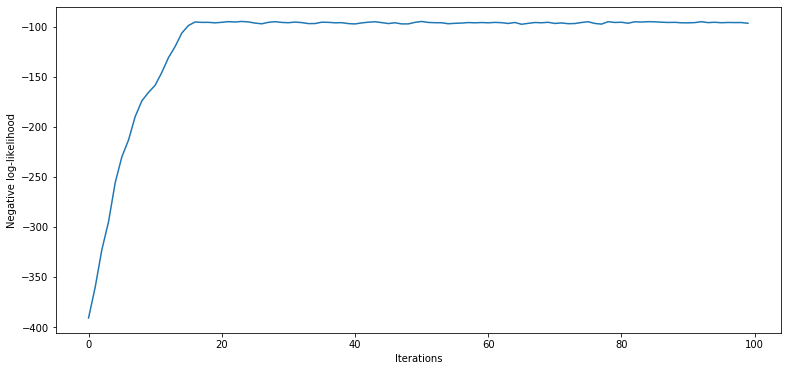

In [26]:
plt.figure(figsize=(13,6))
plt.plot(track_score)
plt.xlabel('Iterations')
plt.ylabel('Negative log-likelihood')
plt.show()